In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

#Keras
from keras.models import Model, Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import image
from keras.preprocessing.sequence import pad_sequences

#Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder

#Сторонние либы
import time
import os
from PIL import Image

#Базовые слои
from keras.layers import Input, concatenate, Activation, Reshape, Flatten, Dense, LSTM, GRU, Embedding

#Свертка
from keras.layers import Conv1D, Conv2D, Conv3D, MaxPooling1D, MaxPooling2D, MaxPooling3D
from keras.layers import Conv1DTranspose, Conv2DTranspose, Conv3DTranspose
from keras.layers import GlobalMaxPooling1D, GlobalMaxPooling2D, GlobalMaxPooling3D

#Регуляризация
from keras.layers import Dropout, BatchNormalization
from keras.layers import SpatialDropout1D, SpatialDropout2D, SpatialDropout3D

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def readText(fileName):
    f = open(fileName, 'r', encoding='utf-8')
    text = f.read()
    text = text.replace('/n', ' ')
    return text

In [4]:
className = ["О. Генри", "Стругацкие", "Булгаков", "Клиффорд_Саймак", "Макс Фрай", "Брэдберри"]
nClasses = len(className)

In [5]:
trainText = []
testText = []

trainText.append(readText('/content/drive/MyDrive/PythonCode/УИИ/4 (NLP)/texts/(Булгаков) Обучающая_5 вместе.txt'))
trainText.append(readText('/content/drive/MyDrive/PythonCode/УИИ/4 (NLP)/texts/(Клиффорд_Саймак) Обучающая_5 вместе.txt'))
trainText.append(readText('/content/drive/MyDrive/PythonCode/УИИ/4 (NLP)/texts/(Макс Фрай) Обучающая_5 вместе.txt'))
trainText.append(readText('/content/drive/MyDrive/PythonCode/УИИ/4 (NLP)/texts/(О. Генри) Обучающая_50 вместе.txt'))
trainText.append(readText('/content/drive/MyDrive/PythonCode/УИИ/4 (NLP)/texts/(Рэй Брэдберри) Обучающая_22 вместе.txt'))
trainText.append(readText('/content/drive/MyDrive/PythonCode/УИИ/4 (NLP)/texts/(Стругацкие) Обучающая_5 вместе.txt'))

testText.append(readText('/content/drive/MyDrive/PythonCode/УИИ/4 (NLP)/texts/(Булгаков) Тестовая_2 вместе.txt'))
testText.append(readText('/content/drive/MyDrive/PythonCode/УИИ/4 (NLP)/texts/(Клиффорд_Саймак) Тестовая_2 вместе.txt'))
testText.append(readText('/content/drive/MyDrive/PythonCode/УИИ/4 (NLP)/texts/(Макс Фрай) Тестовая_2 вместе.txt'))
testText.append(readText('/content/drive/MyDrive/PythonCode/УИИ/4 (NLP)/texts/(О. Генри) Тестовая_20 вместе.txt'))
testText.append(readText('/content/drive/MyDrive/PythonCode/УИИ/4 (NLP)/texts/(Рэй Брэдберри) Тестовая_8 вместе.txt'))
testText.append(readText('/content/drive/MyDrive/PythonCode/УИИ/4 (NLP)/texts/(Стругацкие) Тестовая_2 вместе.txt'))

In [6]:
maxWord = 20000

tokenizer = Tokenizer(num_words=maxWord, oov_token='unknown')
tokenizer.fit_on_texts(trainText)

trainTextindexes = tokenizer.texts_to_sequences(trainText)
testTextindexes = tokenizer.texts_to_sequences(testText)

In [7]:
print(len(trainText))

6


In [8]:
# Формирование обучающей выборки по листу индексов слов
# (разделение на короткие векторы)
def getSetFromIndexes(wordIndexes, xLen, step): # функция принимает последовательность индексов, размер окна, шаг окна
  xSample = [] # Объявляем переменную для векторов
  wordsLen = len(wordIndexes) # Считаем количество слов
  index = 0 # Задаем начальный индекс 

  while (index + xLen <= wordsLen):# Идём по всей длине вектора индексов
    xSample.append(wordIndexes[index:index+xLen]) # "Откусываем" векторы длины xLen
    index += step # Смещаеммся вперёд на step
    
  return xSample

In [9]:
# Формирование обучающей и проверочной выборки
# Из двух листов индексов от двух классов
def createSetsMultiClasses(wordIndexes, xLen, step): # Функция принимает последовательность индексов, размер окна, шаг окна

  # Для каждого из 6 классов
  # Создаём обучающую/проверочную выборку из индексов
  nClasses = len(wordIndexes) # Задаем количество классов выборки
  classesXSamples = []        # Здесь будет список размером "кол-во классов*кол-во окон в тексте*длину окна (например, 6 по 1341*1000)"
  for wI in wordIndexes:      # Для каждого текста выборки из последовательности индексов
    classesXSamples.append(getSetFromIndexes(wI, xLen, step)) # Добавляем в список очередной текст индексов, разбитый на "кол-во окон*длину окна" 

  # Формируем один общий xSamples
  xSamples = [] # Здесь будет список размером "суммарное кол-во окон во всех текстах*длину окна (например, 15779*1000)"
  ySamples = [] # Здесь будет список размером "суммарное кол-во окон во всех текстах*вектор длиной 6"
  
  for t in range(nClasses): # В диапазоне кол-ва классов(6)
    xT = classesXSamples[t] # Берем очередной текст вида "кол-во окон в тексте*длину окна"(например, 1341*1000)
    for i in range(len(xT)): # И каждое его окно
      xSamples.append(xT[i]) # Добавляем в общий список выборки
      ySamples.append(tf.keras.utils.to_categorical(t, nClasses)) # Добавляем соответствующий вектор класса

  xSamples = np.array(xSamples) # Переводим в массив numpy для подачи в нейронку
  ySamples = np.array(ySamples) # Переводим в массив numpy для подачи в нейронку

  
  return (xSamples, ySamples) #Функция возвращает выборку и соответствующие векторы классов

In [10]:
#Задаём базовые параметры
xLen = 1000 #Длина отрезка текста, по которой анализируем, в словах
step = 100 #Шаг разбиения исходного текста на обучающие векторы

x_train, y_train = createSetsMultiClasses(trainTextindexes, xLen, step) #извлекаем обучающую выборку
x_test, y_test = createSetsMultiClasses(testTextindexes, xLen, step)    #извлекаем тестовую выборку
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(18417, 1000)
(18417, 6)
(6968, 1000)
(6968, 6)


In [11]:
x_train_bow = tokenizer.sequences_to_matrix(x_train.tolist())
x_test_bow = tokenizer.sequences_to_matrix(x_test.tolist())


In [12]:
x_train_bow.shape

(18417, 20000)

In [13]:
def createBOW():
    inp = Input(shape=(20000,))
    x1 = Dense(64, activation='relu')(inp)
    x1 = Dropout(0.3)(x1)
    x1 = Dense(128, activation='relu')(x1)
    x1 = Dropout(0.3)(x1)
    x1 = Dense(64, activation='relu')(x1)
    x1 = Dropout(0.3)(x1)
    out = Dense(6, activation='softmax')(x1)

    model = Model(inp, out)

    return model

In [14]:
def createEmb():
    inp = Input(shape=(1000,))
    x = Embedding(maxWord, 5, input_length=xLen)(inp)
    x = SpatialDropout1D(0.3)(x)
    x = LSTM(80, return_sequences=True)(x)
    x = SpatialDropout1D(0.3)(x)
    x = Conv1D(64, 5, padding='same')(x)
    x = MaxPooling1D()(x)
    x = SpatialDropout1D(0.3)(x)
    x = Conv1D(64, 5, padding='same')(x)
    x = MaxPooling1D()(x)
    out = GlobalMaxPooling1D()(x)
    model = Model(inp, out)

    return model


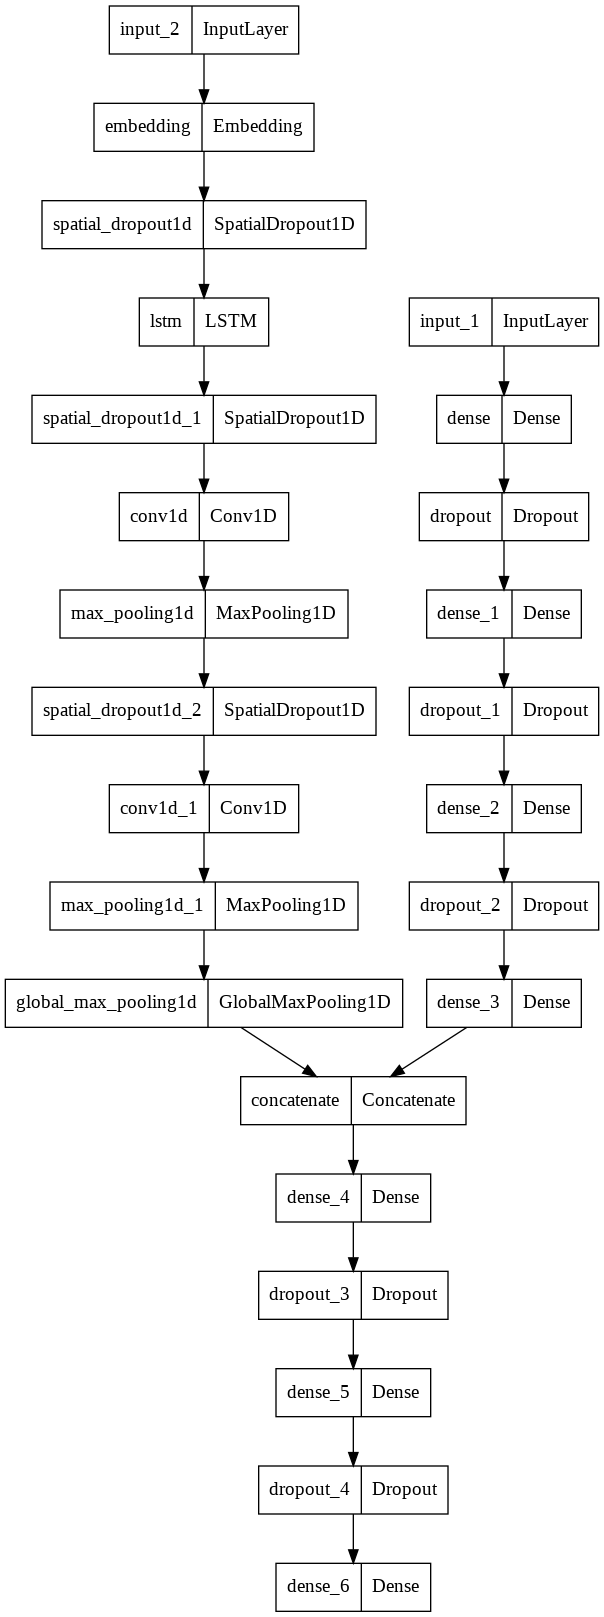

In [15]:
bow = createBOW()
emb = createEmb()
combined = concatenate([bow.output, emb.output])
x = Dense(64, activation='relu')(combined)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
out = Dense(6, activation='softmax')(x)

model = Model(inputs=[bow.input, emb.input], outputs=out)
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
tf.keras.utils.plot_model(model)

In [ ]:
model.fit([x_train_bow, x_train], y_train, epochs=15, batch_size=64, validation_data=([x_test_bow, x_test], y_test))


Epoch 1/15
288/288 [==============================] - 65s 179ms/step - loss: 0.6795 - accuracy: 0.7273 - val_loss: 2.0048 - val_accuracy: 0.6188
Epoch 2/15
288/288 [==============================] - 50s 173ms/step - loss: 0.1109 - accuracy: 0.9614 - val_loss: 1.6538 - val_accuracy: 0.6914
Epoch 3/15
288/288 [==============================] - 54s 187ms/step - loss: 0.0390 - accuracy: 0.9890 - val_loss: 1.4596 - val_accuracy: 0.7450
Epoch 4/15
288/288 [==============================] - 50s 173ms/step - loss: 0.0275 - accuracy: 0.9919 - val_loss: 1.0879 - val_accuracy: 0.7824
Epoch 5/15
288/288 [==============================] - 50s 172ms/step - loss: 0.0222 - accuracy: 0.9938 - val_loss: 1.6881 - val_accuracy: 0.7226
Epoch 6/15
288/288 [==============================] - 50s 172ms/step - loss: 0.0167 - accuracy: 0.9950 - val_loss: 2.0100 - val_accuracy: 0.7229
Epoch 7/15
288/288 [==============================] - 50s 173ms/step - loss: 0.0160 - accuracy: 0.9954 - val_loss: 1.0492 - val_ac